Exercise 1

1. Generate strings of length 15 over the alphabet a, b, c, d

2. Label your strings basing on matching a 5-element regular expression

3. Balance your dataset of size 10000 so that approximately half of the dataset contains regex-matching parts.

4. Prepare your data for training using one-hot encoding

5. Divide your dataset into training and testing parts.

6. Implement and train a model consisting of one convolutional layer with one filter followed by one fully-connected layer and train it to classify your strings. After training, examine the values of the filter

7. Implement and train more complex models (more filters, layers) and analyze their performance on the prepared dataset.

In [241]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
def generate_string(length = 15, alphabet = "abcd", pattern = "cabad", contains = True):
      
      pattern_len = len(pattern)
      if contains: 
            # we need to generate prefix and sufix to our pattern both might be 0 lentgth ofc 
            prefix_len = random.randint(0,length - pattern_len)
            suffix_len = length - pattern_len - prefix_len
            prefix = ''.join(random.choices("abcd" , k=prefix_len))
            suffix = ''.join(random.choices("abcd" , k=suffix_len))
            return prefix + pattern + suffix
      else: 
            while True:
                  candidate = ''.join(random.choices("abcd" , k=length))
                  if pattern not in candidate:
                        return candidate
def generate_dataset(size = 10000):
      expressions = []
      labels = []
      half = size // 2
      
      
      for _ in range(half):
            expressions.append(generate_string(length=15,alphabet="abcd",pattern="cabad",contains=True))
            labels.append(1)
      for _ in range(size- half):
            expressions.append(generate_string(length=15,alphabet="abcd",pattern="cabad",contains=False))
            labels.append(0)
            
      return pd.DataFrame({"expressions":expressions,"contains_abcd":labels})

In [242]:
generate_string(contains=False)

'bdcbccdaddbdcdb'

In [243]:
df = generate_dataset()

In [244]:
df

,expressions,contains_abcd
0,cabadbcccadcccc,1
1,aaacbaccabadcda,1
2,bdacabadbccabba,1
3,bcbccbbcabadacb,1
4,cabadadbabddaba,1
...,...,...
9995,ccadaaadbabddcb,0
9996,ccbbdddcdcddcdc,0
9997,dcdcacbcbdcbdad,0
9998,bbabddaadbdcbdc,0


In [245]:
char_indexes = {'a':0,'b':1,'c':2,'d':3}
num_classes = 4

In [246]:
def one_hot_encode_expression(s,map,num_classes):
    one_hot = torch.zeros(size = (len(s),num_classes))
    for i, char in enumerate(s):
        one_hot[i,map[char]] = 1 
    return one_hot
def one_hot_encode_dataset(dataset,shape,map):
    table = torch.empty(size = shape)
    for i,s in enumerate(dataset.iloc[:,0]):
        table[i] = one_hot_encode_expression(s,map = map,num_classes= shape[-1])
    return table

In [247]:
def decode_character(char,characters = ['a','b','c','d']):
    index = torch.argmax(char)
    return characters[index]

def decode_string(dataset, index):
    expression = ""
    for letter in dataset[index]:
        expression += decode_character(letter)
    return expression

In [248]:
s = generate_string()

In [249]:
one_hot_encode_expression(s,char_indexes,num_classes)

tensor([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])

In [250]:
dataset = torch.empty(size = (10000,15,4))

In [251]:
def one_hot_encode_dataset(dataset,shape,map):
    table = torch.empty(size = shape)
    for i,s in enumerate(dataset.iloc[:,0]):
        table[i] = one_hot_encode_expression(s,map = map,num_classes= shape[-1])
    return table

In [252]:
X = one_hot_encode_dataset(dataset=df,shape = (10000,15,4),map =char_indexes)

In [253]:
decode_string(dataset=X,index=5000) == df.iloc[5000,0]  # to make sure that one hot encoding works correctly 

True

In [254]:
y = torch.tensor(data=df.iloc[:,1])  

In [256]:
from sklearn.model_selection import train_test_split

In [257]:
X_train , X_test , y_train , y_test = train_test_split(X.view(10000,4,15),y,test_size=0.2)

In [265]:
# create simple conv model 
class SimpleConvNet(nn.Module):
    # in channels is equal to number of alphabet letters from which dataset is constructed 4 in case of abcd 
    # 1 out channels = one filter 
    # let's go with kernel size equal to pattern length 5 in oour case
    def __init__(self,num_chars,pattern_len):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=num_chars , out_channels = 1,kernel_size= pattern_len,bias = False),
                                   nn.ReLU())
        self.fc = nn.Linear(in_features=11,out_features=1,bias= False)
    def forward(self,x):
        x = self.conv1(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

In [266]:
model = SimpleConvNet(num_chars=4,pattern_len=5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss = nn.BCEWithLogitsLoss()

In [267]:
X_train.shape

torch.Size([8000, 4, 15])

create custom dataset 

In [268]:
from torch.utils.data import DataLoader, TensorDataset

    
# Create Dataset instances
train_dataset = TensorDataset(X_train, y_train.unsqueeze(1).type(torch.float32))
test_dataset = TensorDataset(X_test, y_test.unsqueeze(1).type(torch.float32))




In [269]:
batch_size = 10
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)


In [270]:
def train(model,
          dataloader,
          loss_fn,
          optimizer,
          epochs = 10):
    
    for epoch in range(epochs):
    # put model in train mode
    

      
      # setrup train loss and accuracy 
      model.train()
      train_loss , train_acc = 0,0
      # loop through dataloader in batches 
      for batch, (X,y) in enumerate(dataloader):
            

            # forward pass
            y_pred = model(X)
          
            # calcualte loss 
            loss = loss_fn(y_pred,y)
            train_loss += loss.item()
            
            # zero grad
            optimizer.zero_grad()
            
            # loss backward 
            loss.backward()
            
            # optimizer step 
            
            optimizer.step()
        
           
            # Adjust metrics to get average loss  per batch 
      train_loss = train_loss / len(dataloader)
      
      print(f"Epoch{epoch} | train loss {train_loss}")

          

In [271]:
model(X[0].view(1,4,15))

tensor([-0.0939], grad_fn=<SqueezeBackward4>)

In [272]:
train(model=model,
      dataloader=train_dataloader,
      loss_fn=loss,
      optimizer=optimizer,
      epochs=100)

Epoch0 | train loss 0.6555286486074329
Epoch1 | train loss 0.6057020931318402
Epoch2 | train loss 0.5914146407693625
Epoch3 | train loss 0.5863809405267238
Epoch4 | train loss 0.5830105316638946
Epoch5 | train loss 0.5803992609679699
Epoch6 | train loss 0.5781848866119981
Epoch7 | train loss 0.5758644055202603
Epoch8 | train loss 0.5748455246351659
Epoch9 | train loss 0.5737670684792101
Epoch10 | train loss 0.5732675383239985
Epoch11 | train loss 0.5726861315779388
Epoch12 | train loss 0.5718848325684667
Epoch13 | train loss 0.5714852344617247
Epoch14 | train loss 0.5711467188596725
Epoch15 | train loss 0.570984202362597
Epoch16 | train loss 0.5704294786415994
Epoch17 | train loss 0.5700107009522617
Epoch18 | train loss 0.5697064151987433
Epoch19 | train loss 0.5693564495816826
Epoch20 | train loss 0.5694944696873426
Epoch21 | train loss 0.5692130570299924
Epoch22 | train loss 0.5691816648468375
Epoch23 | train loss 0.5689776170626283
Epoch24 | train loss 0.5689629244804383
Epoch25 | t

In [273]:
y_test_pred = model(X_test).argmax(dim=1)

In [274]:
def accuracy_fn(y_pred , y):
    counter = 0
    for i in range(len(y)):
        if y[i] != y_pred[i]:
            counter +=1
    return 1 - counter / len(y)

In [275]:
accuracy_fn(y_test_pred,y_test)

0.487

In [276]:
params = model.state_dict()
kernel = params['conv1.0.weight'].view(4,5)

In [277]:
kernel

tensor([[ 0.6802,  0.5050,  0.6802, -1.5794, -0.5521],
        [-0.9250,  1.0620,  1.1711,  0.7767, -2.3699],
        [ 0.0088, -4.1072, -2.4593, -1.6428, -1.4181],
        [ 0.9703,  1.1122,  0.4479,  0.6916,  0.7387]])

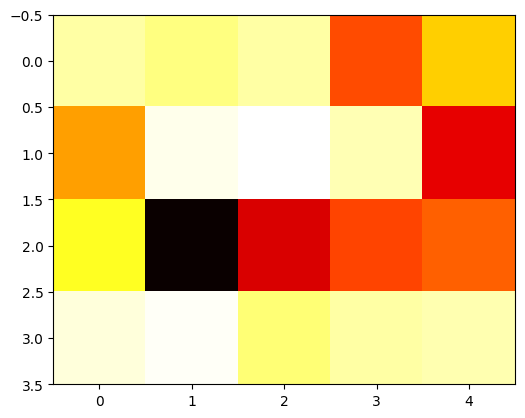

In [278]:
import matplotlib.pyplot as plt
# Display the heatmap
plt.imshow(kernel, cmap='hot')
plt.show()

In [279]:
# create more complex conv model 
class ComplexeConvNet(nn.Module):
    # in channels is equal to number of alphabet letters from which dataset is constructed 4 in case of abcd 
    # 1 out channels = one filter 
    # let's go with kernel size equal to pattern length 5 in oour case
    def __init__(self,num_chars,pattern_len):
        super().__init__()
        self.sequential = nn.Sequential(nn.Conv1d(in_channels=num_chars , out_channels = 32 ,kernel_size= pattern_len,bias = True),
                                   nn.ReLU(),
                                   nn.MaxPool1d(kernel_size=2),
                                   nn.Conv1d(in_channels=32 , out_channels = 64 ,kernel_size= pattern_len,bias = True),
                                   nn.MaxPool1d(kernel_size=2),
                                   nn.Flatten(),
                                   nn.Linear(192,64),
                                   nn.ReLU(),
                                   nn.Linear(in_features=64,out_features=1)
                                   )
      
    def forward(self,x):
       
        return self.sequential(x)


In [280]:
model2 = ComplexeConvNet(num_chars=4,pattern_len=5)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.001)
loss2 = nn.BCEWithLogitsLoss()

In [281]:
train(model=model2,
      dataloader=train_dataloader,
      loss_fn=loss2,
      optimizer=optimizer2,
      epochs=10)

RuntimeError: max_pool1d() Invalid computed output size: 0